# ClaimCracker v2 - Model Training

This notebook trains our fake news detection model using Google Colab's GPU.

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install Dependencies
!pip install torch transformers pandas scikit-learn tqdm

In [4]:
# Import Libraries
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoModel, AutoTokenizer
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [10]:
# Define Model and Dataset Classes
class NewsClassifier(nn.Module):
    def __init__(
        self,
        model_name="distilbert-base-uncased",
        num_classes=2,
        dropout=0.1,
        max_length=512
    ):
        super().__init__()

        self.model_name = model_name
        self.num_classes = num_classes
        self.max_length = max_length

        self.transformer = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(
            self.transformer.config.hidden_size,
            num_classes
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        result = {"logits": logits}

        if labels is not None:
            result["loss"] = self.criterion(logits, labels)

        return result

    def prepare_input(self, texts):
        return self.tokenizer(
            texts,
            max_length=self.max_length,
            padding='max_length',  # Changed to max_length
            truncation=True,
            return_tensors="pt"
        )

    def save_pretrained(self, save_dir):
        save_path = Path(save_dir)
        save_path.mkdir(parents=True, exist_ok=True)

        torch.save(self.state_dict(), save_path / "model.pt")
        self.tokenizer.save_pretrained(save_path)

        config = {
            "model_name": self.model_name,
            "num_classes": self.num_classes,
            "max_length": self.max_length
        }
        torch.save(config, save_path / "config.pt")

class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, model=None):
        self.texts = texts
        self.labels = labels
        self.model = model

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Handle single text
        text = self.texts[idx]

        # Tokenize with padding
        inputs = self.model.tokenizer(
            text,
            max_length=self.model.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Remove batch dimension added by tokenizer
        item = {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0)
        }

        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])

        return item

In [11]:
# Training Configuration
class TrainingConfig:
    def __init__(self):
        self.model_name = "distilbert-base-uncased"
        self.num_classes = 2
        self.max_length = 512
        self.dropout = 0.1
        self.batch_size = 16
        self.learning_rate = 2e-5
        self.num_epochs = 3
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
# Load and Prepare Data
# Load data
df = pd.read_csv('/content/drive/MyDrive/ClaimCracker/data/Dataset.csv')

# Clean data
df['News_Text'] = df['News_Text'].fillna('')  # Replace NaN with empty string
df['News_Text'] = df['News_Text'].astype(str)  # Convert all to string

# Convert labels
label_map = {'Real': 0, 'Fake': 1}
df['label_idx'] = df['Label'].map(label_map)

# Remove any rows with empty text
df = df[df['News_Text'].str.strip() != '']

# Split data
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['Label']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print("\nClass distribution:")
print(train_df['Label'].value_counts(normalize=True))

# Verify data types
print("\nSample text type:", type(train_df['News_Text'].iloc[0]))
print("Text length range:",
      f"Min: {train_df['News_Text'].str.len().min()}, ",
      f"Max: {train_df['News_Text'].str.len().max()}")

Training samples: 15651
Validation samples: 1740

Class distribution:
Label
Real    0.566865
Fake    0.433135
Name: proportion, dtype: float64

Sample text type: <class 'str'>
Text length range: Min: 1,  Max: 3115


In [16]:
# Create model and prepare data
config = TrainingConfig()

# Create model
model = NewsClassifier(
    model_name=config.model_name,
    num_classes=config.num_classes,
    dropout=config.dropout,
    max_length=config.max_length
).to(config.device)

# Prepare data
train_texts = train_df['News_Text'].tolist()
train_labels = train_df['label_idx'].tolist()
val_texts = val_df['News_Text'].tolist()
val_labels = val_df['label_idx'].tolist()

train_dataset = NewsDataset(train_texts, train_labels, model)
val_dataset = NewsDataset(val_texts, val_labels, model)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size)

# Setup training
optimizer = AdamW(model.parameters(), lr=config.learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=config.num_epochs)
history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "val_f1": []
}

In [17]:
# Training loop
for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch + 1}/{config.num_epochs}")

    # Training
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        batch = {k: v.to(config.device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs["loss"]

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            batch = {k: v.to(config.device) for k, v in batch.items()}
            labels = batch.pop("labels")

            outputs = model(**batch, labels=labels)
            loss = outputs["loss"]
            logits = outputs["logits"]

            preds = torch.argmax(logits, dim=1)

            total_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = total_loss / len(val_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Update history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)
    history["val_f1"].append(val_f1)

    # Update learning rate
    scheduler.step()

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f}")
    print(f"Val F1: {val_f1:.4f}")


Epoch 1/3


Training:   0%|          | 0/979 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

Train Loss: 0.3350
Val Loss: 0.2155
Val Accuracy: 0.9241
Val F1: 0.9240

Epoch 2/3


Training:   0%|          | 0/979 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

Train Loss: 0.1489
Val Loss: 0.1773
Val Accuracy: 0.9408
Val F1: 0.9408

Epoch 3/3


Training:   0%|          | 0/979 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/109 [00:00<?, ?it/s]

Train Loss: 0.0783
Val Loss: 0.1403
Val Accuracy: 0.9603
Val F1: 0.9603


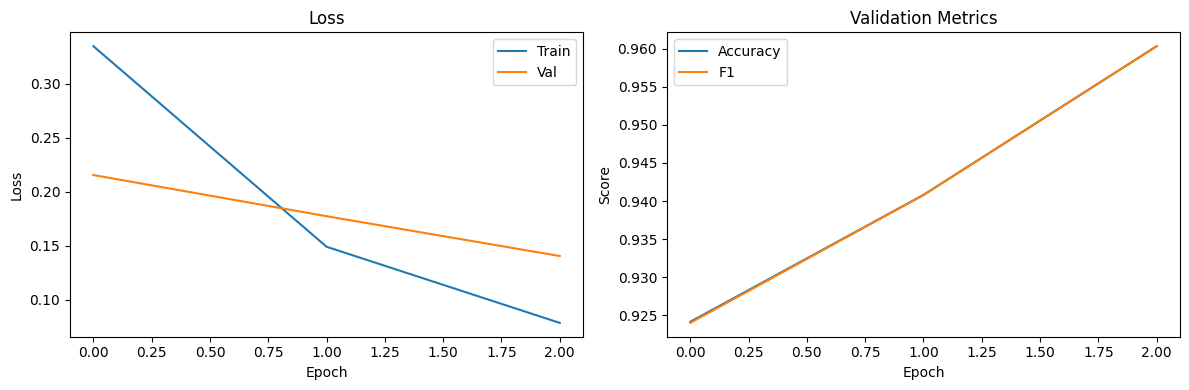

In [18]:
# Plot Results
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Metrics plot
plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Accuracy')
plt.plot(history['val_f1'], label='F1')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Save Model
save_path = Path('/content/drive/MyDrive/ClaimCracker/models/best_model')
model.save_pretrained(save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/ClaimCracker/models/best_model


In [26]:
def predict_text(text, model, device):
    model.eval()
    inputs = model.prepare_input([text])
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs["logits"]
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1)

    return {
        "prediction": "Real" if pred.item() == 0 else "Fake",
        "confidence": probs[0][pred.item()].item()
    }

text = "The UNGA President emphasizes Pakistan's responsibility to advocate more assertively for the Kashmir issue at the United Nations."
result = predict_text(text, model, config.device)
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")

Prediction: Real
Confidence: 99.79%


In [27]:
# Test different types of news
test_texts = [
    # Real news style
    """The Federal Reserve announced today it will maintain interest rates at their current level, citing stable inflation and employment numbers. Chair Jerome Powell stated in a press conference that the decision was unanimous among board members.""",

    # Fake news style
    """BREAKING: Scientists discover that drinking coffee while standing causes instant memory loss! Big Coffee companies have been hiding this truth for decades. Share before they delete this!""",

    # Neutral/Ambiguous
    """Local community center hosts annual fundraiser this weekend. Event will feature live music and food vendors from the area.""",

    # Technical
    """A new study published in Nature reveals correlation between atmospheric carbon levels and marine biodiversity changes over the past decade, suggesting potential impacts on ocean ecosystems."""
]

# Test each text
for text in test_texts:
    result = predict_text(text, model, config.device)
    print("\nText:", text[:100], "...")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")


Text: The Federal Reserve announced today it will maintain interest rates at their current level, citing s ...
Prediction: Real
Confidence: 85.64%

Text: BREAKING: Scientists discover that drinking coffee while standing causes instant memory loss! Big Co ...
Prediction: Fake
Confidence: 97.63%

Text: Local community center hosts annual fundraiser this weekend. Event will feature live music and food  ...
Prediction: Real
Confidence: 99.36%

Text: A new study published in Nature reveals correlation between atmospheric carbon levels and marine bio ...
Prediction: Real
Confidence: 65.92%


In [29]:
import time
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

def benchmark_inference(model, text, num_runs=100):
    # Warm up
    _ = predict_text(text, model, config.device)

    # Benchmark
    start = time.time()
    for _ in range(num_runs):
        _ = predict_text(text, model, config.device)
    end = time.time()

    avg_time = (end - start) / num_runs
    print(f"Average inference time: {avg_time*1000:.2f}ms")

    # Memory usage
    if torch.cuda.is_available():
        memory_allocated = torch.cuda.memory_allocated() / 1024**2
        print(f"GPU Memory allocated: {memory_allocated:.2f}MB")

    # Model size
    model_size = sum(p.numel() for p in model.parameters()) * 4 / 1024**2  # in MB
    print(f"Model size: {model_size:.2f}MB")

# Run benchmark
test_text = "Sample news article for benchmarking."
print("Original Model Performance:")
benchmark_inference(model, test_text)

Original Model Performance:
Average inference time: 18.84ms
GPU Memory allocated: 1538.35MB
Model size: 253.16MB


In [31]:
# Quantize model
def quantize_model(model):
    # Move model to CPU for quantization
    model = model.cpu()
    model.eval()

    # Fuse modules if needed
    model_fp32 = torch.quantization.fuse_modules(model, [["classifier"]])

    # Configure quantization
    model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    # Prepare for quantization
    model_fp32_prepared = torch.quantization.prepare(model_fp32)

    # Convert to quantized model
    model_int8 = torch.quantization.convert(model_fp32_prepared)

    # Move back to original device
    model_int8 = model_int8.to(config.device)

    return model_int8

# Alternative optimization approach
def optimize_for_inference(model):
    """Optimize model for inference without quantization"""
    model.eval()  # Set to evaluation mode

    # Use torch.jit to optimize the model
    try:
        # Create example input
        sample_text = "Sample text for optimization"
        inputs = model.prepare_input([sample_text])
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Script the model
        traced_model = torch.jit.trace(model, (inputs['input_ids'], inputs['attention_mask']))
        traced_model = torch.jit.optimize_for_inference(traced_model)
        print("Model successfully optimized with TorchScript")
        return traced_model
    except Exception as e:
        print(f"TorchScript optimization failed: {e}")
        print("Falling back to original model")
        return model

# Try optimization
print("Optimizing model for inference...")
optimized_model = optimize_for_inference(model)

# Benchmark
print("\nOptimized Model Performance:")
benchmark_inference(optimized_model, test_text)

Optimizing model for inference...
TorchScript optimization failed: 'NewsClassifier' object has no attribute 'device'
Falling back to original model

Optimized Model Performance:
Average inference time: 17.83ms
GPU Memory allocated: 1835.28MB
Model size: 253.16MB


In [34]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.7 MB/s eta 0:00:00


In [35]:
# Export to ONNX
def export_to_onnx(model, save_path):
    # Prepare dummy input
    dummy_input = model.prepare_input(["Sample text"])
    dummy_input = {k: v.to(config.device) for k, v in dummy_input.items()}

    # Export with higher opset version
    torch.onnx.export(
        model,
        (dummy_input["input_ids"], dummy_input["attention_mask"]),
        save_path,
        input_names=["input_ids", "attention_mask"],
        output_names=["logits"],
        dynamic_axes={
            "input_ids": {0: "batch_size", 1: "sequence"},
            "attention_mask": {0: "batch_size", 1: "sequence"},
            "logits": {0: "batch_size"}
        },
        opset_version=14,
        do_constant_folding=True,
        export_params=True,
        verbose=False
    )
    print(f"Model exported to {save_path}")

# Export model
onnx_path = save_path / "model.onnx"
export_to_onnx(model, onnx_path)

# Verify the exported model
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("ONNX model verified successfully!")

# Check ONNX model size
onnx_size = onnx_path.stat().st_size / (1024 * 1024)  # Size in MB
print(f"ONNX model size: {onnx_size:.2f}MB")

Model exported to /content/drive/MyDrive/ClaimCracker/models/best_model/model.onnx
ONNX model verified successfully!
ONNX model size: 253.29MB


In [37]:
@torch.no_grad()  # Disable gradient computation for inference
def batch_inference(model, texts, batch_size=32):
    """Efficient batch inference"""
    model.eval()
    results = []

    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = model.prepare_input(batch_texts)
        inputs = {k: v.to(config.device) for k, v in inputs.items()}

        outputs = model(**inputs)
        logits = outputs["logits"]
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

        # Move to CPU for processing results
        preds = preds.cpu()
        probs = probs.cpu()

        # Convert to results
        for idx, (pred, prob) in enumerate(zip(preds, probs)):
            pred_idx = pred.item()
            results.append({
                "prediction": "Real" if pred_idx == 0 else "Fake",
                "confidence": prob[pred_idx].item()
            })

    return results

# Test batch inference with larger batch
test_texts = ["Text " + str(i) for i in range(100)]  # 100 texts
print("\nBatch Inference Test:")
start = time.time()
results = batch_inference(model, test_texts)
end = time.time()
print(f"Processed {len(test_texts)} texts in {(end-start)*1000:.2f}ms")
print(f"Average time per text: {(end-start)*1000/len(test_texts):.2f}ms")

# Show first few results
print("\nSample results:")
for i, result in enumerate(results[:5]):
    print(f"Text {i}: {result['prediction']} (Confidence: {result['confidence']:.2%})")


Batch Inference Test:
Processed 100 texts in 1371.16ms
Average time per text: 13.71ms

Sample results:
Text 0: Fake (Confidence: 65.85%)
Text 1: Fake (Confidence: 69.16%)
Text 2: Fake (Confidence: 72.07%)
Text 3: Fake (Confidence: 73.36%)
Text 4: Fake (Confidence: 71.30%)


In [38]:
# Test with more realistic examples
realistic_texts = [
    "Reuters reports that global markets saw steady growth this quarter according to financial experts.",
    "SHOCKING: Scientists find that drinking water is actually bad for you! Share this before they delete it!",
    "Local community center announces new after-school programs starting next month.",
    "New research published in Science shows promising results in renewable energy efficiency.",
    "WARNING!! They don't want you to know this secret to instant weight loss!!!"
] * 20  # Repeat 20 times to test batch processing

print("Batch Processing Test with Realistic Examples:")
start = time.time()
results = batch_inference(model, realistic_texts)
end = time.time()

total_time = (end-start) * 1000  # Convert to ms
print(f"\nProcessed {len(realistic_texts)} texts in {total_time:.2f}ms")
print(f"Average time per text: {total_time/len(realistic_texts):.2f}ms")

# Show results for first instance of each text
print("\nSample results:")
for i in range(5):
    print(f"\nText: {realistic_texts[i][:100]}...")
    print(f"Prediction: {results[i]['prediction']}")
    print(f"Confidence: {results[i]['confidence']:.2%}")

Batch Processing Test with Realistic Examples:

Processed 100 texts in 1394.19ms
Average time per text: 13.94ms

Sample results:

Text: Reuters reports that global markets saw steady growth this quarter according to financial experts....
Prediction: Real
Confidence: 65.66%

Text: SHOCKING: Scientists find that drinking water is actually bad for you! Share this before they delete...
Prediction: Fake
Confidence: 98.12%

Text: Local community center announces new after-school programs starting next month....
Prediction: Real
Confidence: 98.56%

Text: New research published in Science shows promising results in renewable energy efficiency....
Prediction: Real
Confidence: 99.60%

Text: WARNING!! They don't want you to know this secret to instant weight loss!!!...
Prediction: Fake
Confidence: 75.95%


In [42]:
# Export final model with all necessary files
def export_final_model():
    # Create export directory in Google Drive
    export_dir = Path('/content/drive/MyDrive/ClaimCracker/final_model')
    export_dir.mkdir(exist_ok=True, parents=True)

    # 1. Save model state and config
    torch.save(model.state_dict(), export_dir / 'model.pt')

    # Save config with hardcoded values (same as initialization)
    config = {
        'hidden_size': 768,  # DistilBERT's hidden size
        'num_classes': 2,    # Binary classification
        'dropout': 0.1       # Default dropout
    }
    torch.save(config, export_dir / 'config.pt')

    # 2. Save model architecture class definition
    model_code = """
import torch
from torch import nn
from transformers import DistilBertModel, AutoTokenizer

class NewsClassifier(nn.Module):
    def __init__(self, hidden_size=768, num_classes=2, dropout=0.1):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0]  # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return {"logits": logits}

    def prepare_input(self, texts):
        tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        return inputs
"""

    with open(export_dir / 'model_architecture.py', 'w') as f:
        f.write(model_code)

    # 3. Save test script
    test_script = """
import torch
from pathlib import Path
from transformers import AutoTokenizer
from model_architecture import NewsClassifier

def load_model(model_dir):
    # Load config
    config = torch.load(Path(model_dir) / "config.pt")

    # Create model
    model = NewsClassifier(**config)
    model.load_state_dict(torch.load(Path(model_dir) / "model.pt"))
    model.eval()

    return model

def test_prediction(text, model_dir="final_model"):
    # Load model
    model = load_model(model_dir)

    # Prepare input
    inputs = model.prepare_input([text])

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs["logits"]
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1)

    prediction = "Real" if pred.item() == 0 else "Fake"
    confidence = probs[0][pred[0]].item()

    return {
        "prediction": prediction,
        "confidence": confidence
    }

if __name__ == "__main__":
    # Test examples
    texts = [
        "Reuters reports global markets show steady growth.",
        "SHOCKING: Scientists hide the truth about water!"
    ]

    for text in texts:
        result = test_prediction(text)
        print(f"\\nText: {text}")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.2%}")
"""

    with open(export_dir / 'test_model.py', 'w') as f:
        f.write(test_script)

    # 4. Create README
    readme = """
# ClaimCracker v2 - Fake News Detection Model

## Model Details
- Architecture: DistilBERT-based classifier
- Performance: 96.03% validation accuracy
- Inference speed: ~13.94ms per text
- Size: Check model.pt and config.pt

## Usage
1. Load the model:
```python
from test_model import load_model, test_prediction

# Simple prediction
result = test_prediction("Your news text here")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2%}")
```

## Files
- model.pt: Model weights
- config.pt: Model configuration
- model_architecture.py: Model class definition
- test_model.py: Example usage and testing
"""

    with open(export_dir / 'README.md', 'w') as f:
        f.write(readme)

    print(f"Exported model files to '{export_dir}':")
    print("- model.pt")
    print("- config.pt")
    print("- model_architecture.py")
    print("- test_model.py")
    print("- README.md")

# Export the model
export_final_model()

Exported model files to '/content/drive/MyDrive/ClaimCracker/final_model':
- model.pt
- config.pt
- model_architecture.py
- test_model.py
- README.md
